In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

### Read data from parquet 

In [3]:
def read_dataframe(filename: str) -> pd.DataFrame:
    # Load data based on file extension
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    else:
        raise ValueError("Unsupported file format. Use .csv or .parquet")

    # Convert datetime columns
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

    # Compute trip duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Filter out trips with duration outside 1–60 minutes
    df = df.loc[df['duration'].between(1, 60)].copy()

    # Cast categorical columns to string
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


In [4]:
df_train = read_dataframe('../data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [5]:
len(df_train), len(df_val)

(3009173, 2855951)

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.247519676439711

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

In [11]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

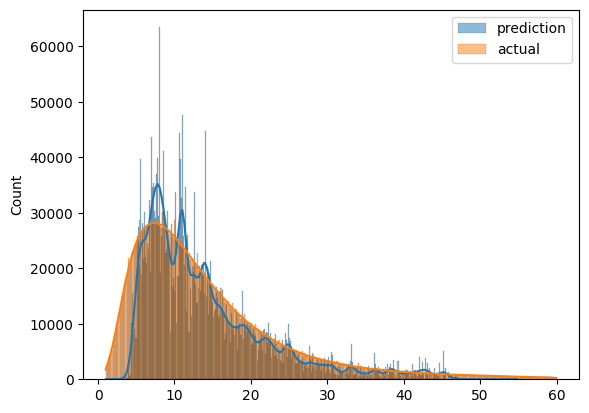

In [10]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual',kde=True)

plt.legend()